# Full Image Size

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image

import cv2

img_path = 'images/00000001_000.png'

image = Image.open(img_path).convert("L")
image = image.resize((256, 256))
arr = np.asarray(image)
plt.imshow(arr, cmap = 'gray')
plt.show()

<Figure size 640x480 with 1 Axes>

# Test

In [2]:
import numpy as np
import pandas as pd
import matplotlib.image as img
import matplotlib.pyplot as plt
from tqdm import tqdm
import os, cv2

TRAIN_DIR = '/Users/ellischang/ellis_venv/URE18/Image_Processing/images'
TEST_DIR = '/Users/ellischang/ellis_venv/URE18/Image_Processing/test_images'
LABEL_DIR = 'Data_Entry_2017.csv'
IMG_SIZE = 256

In [3]:
# One Hot Encode for Multiple Labels
from sklearn.preprocessing import MultiLabelBinarizer

read_data = pd.read_csv(LABEL_DIR)
split_labels = [items.split('|') for items in read_data.Finding_Labels]
one_hot = MultiLabelBinarizer()
onehot_labels = one_hot.fit_transform(split_labels)
test_labels = onehot_labels[4500:5000]
training_labels = onehot_labels[:4500]

In [4]:
print(len(training_labels))
print(len(test_labels))

4500
500


In [5]:
def process(directory):
    img_array = []
    for subdir, dirs, files in os.walk(directory):
        for filename in tqdm(files):
            path = subdir + os.sep + filename
            img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
            img_array.append(img)
    return img_array

In [6]:
training_img = process(TRAIN_DIR)
training_img = np.array(training_img)
training_img = np.expand_dims(training_img, axis = 3)

100%|██████████| 4500/4500 [02:02<00:00, 36.84it/s]


In [8]:
test_img = process(TEST_DIR)
test_img = np.array(test_img)
test_img = np.expand_dims(test_img, axis = 3)

100%|██████████| 500/500 [00:07<00:00, 64.19it/s]


In [9]:
print(training_img.shape)
print(test_img.shape)

(4500, 256, 256, 1)
(500, 256, 256, 1)


In [10]:
import keras
from keras import models
from keras import layers
from keras import optimizers

Using TensorFlow backend.


In [11]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(15, activation='sigmoid'))

In [12]:
model.compile(optimizer = optimizers.RMSprop(lr = 1e-5), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [13]:
history = model.fit(training_img, training_labels, epochs = 1, validation_split = (1/9), batch_size = 10)

Train on 4000 samples, validate on 500 samples
Epoch 1/1
4000/4000 [==============================] - 528s 132ms/step - loss: 0.5494 - acc: 0.9000 - val_loss: 0.3505 - val_acc: 0.9197


In [14]:
test_loss, test_acc = model.evaluate(test_img, test_labels)

500/500 [==============================] - 16s 32ms/step


In [15]:
test_acc

0.9035999860763549

In [16]:
test_loss

0.408545129776001

# Visualizing Image from Network

In [17]:
from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, grayscale = True, target_size=(256, 256))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

np.set_printoptions(threshold = np.nan, linewidth = 100)
print(img_tensor.shape)
#plt.imshow(img_tensor[0])
#plt.show()

(1, 256, 256, 1)


###### Instantiating Model from and input tensor and a list of output tensors

In [18]:
from keras import models #<==== DONT NEED THIS LINE
#Extracts the outputs of the top eight layers
layer_outputs = [layer.output for layer in model.layers[:8]] #<===== DEFINE THE RIGHT MODEL
#Creates a model that will return the outputs, given the model input
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

###### Running the model in predict mode

In [19]:
#Returns a list of five numpy arrays; one array per layer activation
activations = activation_model.predict(test_img)

first_layer_activation = activations[0]
print(first_layer_activation.shape)
#Book example cat prints out:
# (1, 148, 148, 32) its one 148x148 image with 32 channels
#Printed out 254x254 not 256x256

(500, 254, 254, 32)


###### Visualizing the fourth channel

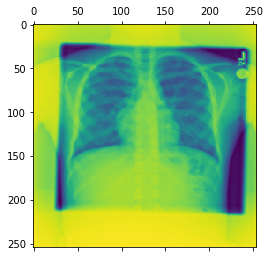

In [20]:
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')
#In the book, this code showed that the fourth channel encoded a diagonal edge detector for the cat image
#NOTE: our channels may vary, because the specific filters learned by convolution layers aren’t deterministic

###### Visualing the seventh channel

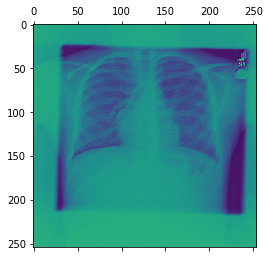

In [21]:
plt.matshow(first_layer_activation[0, :, :, 7], cmap='viridis')
#In the book, this channel was a "bright green detector" which basically encoded a detector for the eyes of the cat

###### Visualing every channel in every intermediate activation

/Users/ellischang/ellis_venv/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


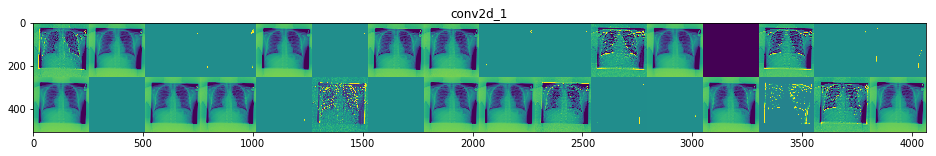

In [22]:
#This code below visualized the images as we saw above for all the channels in every layer.
layer_names = []
for layer in model.layers[:1]:
    layer_names.append(layer.name)
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :,
                                             :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image
            
scale = 1. / size
plt.figure(figsize=(scale * display_grid.shape[1],
                    scale * display_grid.shape[0]))
plt.title(layer_name)
plt.grid(False)
plt.imshow(display_grid, aspect='auto', cmap='viridis')

/Users/ellischang/ellis_venv/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


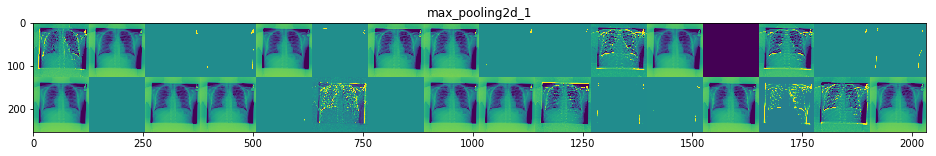

In [23]:
layer_names = []
for layer in model.layers[:2]:
    layer_names.append(layer.name)
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :,
                                             :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image
            
scale = 1. / size
plt.figure(figsize=(scale * display_grid.shape[1],
                    scale * display_grid.shape[0]))
plt.title(layer_name)
plt.grid(False)
plt.imshow(display_grid, aspect='auto', cmap='viridis')

/Users/ellischang/ellis_venv/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


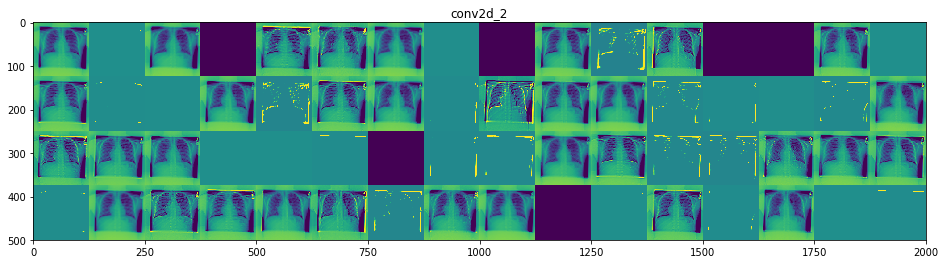

In [24]:
layer_names = []
for layer in model.layers[:3]:
    layer_names.append(layer.name)
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :,
                                             :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image
            
scale = 1. / size
plt.figure(figsize=(scale * display_grid.shape[1],
                    scale * display_grid.shape[0]))
plt.title(layer_name)
plt.grid(False)
plt.imshow(display_grid, aspect='auto', cmap='viridis')

/Users/ellischang/ellis_venv/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


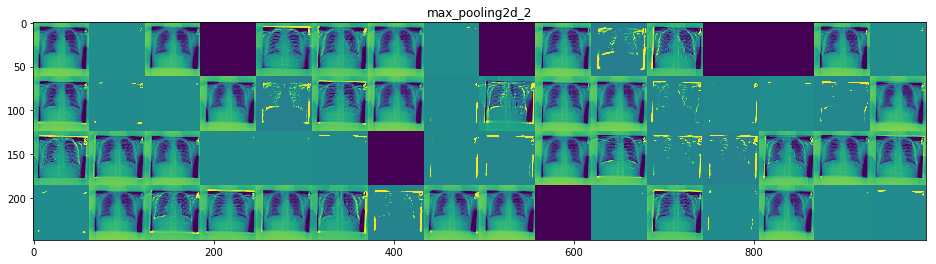

In [25]:
layer_names = []
for layer in model.layers[:4]:
    layer_names.append(layer.name)
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :,
                                             :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image
            
scale = 1. / size
plt.figure(figsize=(scale * display_grid.shape[1],
                    scale * display_grid.shape[0]))
plt.title(layer_name)
plt.grid(False)
plt.imshow(display_grid, aspect='auto', cmap='viridis')

/Users/ellischang/ellis_venv/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


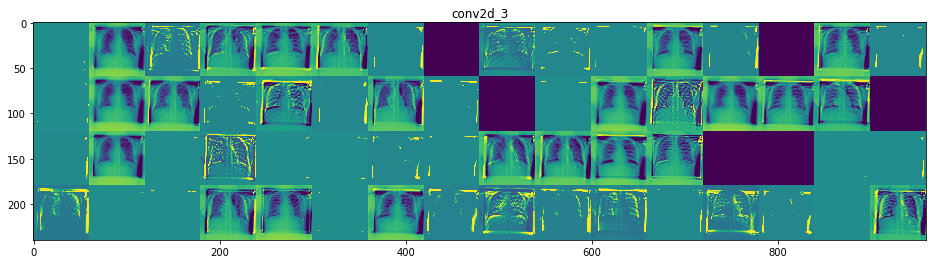

In [26]:
layer_names = []
for layer in model.layers[:5]:
    layer_names.append(layer.name)
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :,
                                             :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image
            
scale = 1. / size
plt.figure(figsize=(scale * display_grid.shape[1],
                    scale * display_grid.shape[0]))
plt.title(layer_name)
plt.grid(False)
plt.imshow(display_grid, aspect='auto', cmap='viridis')

/Users/ellischang/ellis_venv/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


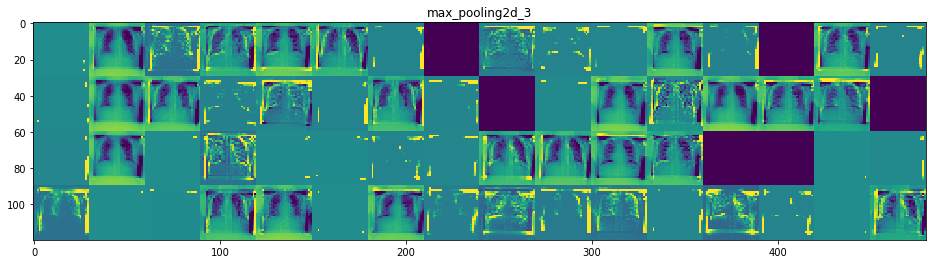

In [27]:
layer_names = []
for layer in model.layers[:6]:
    layer_names.append(layer.name)
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :,
                                             :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image
            
scale = 1. / size
plt.figure(figsize=(scale * display_grid.shape[1],
                    scale * display_grid.shape[0]))
plt.title(layer_name)
plt.grid(False)
plt.imshow(display_grid, aspect='auto', cmap='viridis')

### Code below may not have to use

###### Defining the Loss tensor for filter visualization

from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet',
              include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

###### Obtaining the gradient of the loss with regard to the input

grads = K.gradients(loss, model.input)[0]

###### Gradient-normalization Trick

grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

###### Fetching Numpy output values given Numpy input values

iterate = K.function([model.input], [loss, grads])

import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

###### Loss maximization via stochastic gradient descent

input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

step = 1.

for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    
    input_img_data += grads_value * step

###### Utility function to convert a tensor into a valid image

def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    
    x += 0.5
    x = np.clip(x, 0, 1)
    
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

###### Function to generate filter visualizations

def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    
    grads = K.gradients(loss, model.input)[0]
    
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    
    iterate = K.function([model.input], [loss, grads])
    
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    
    img = input_img_data[0]
    return deprocess_image(img)

plt.imshow(generate_pattern('block3_conv1', 0))

###### Generating a grid of all filter response pattern in a layer

layer_name = 'block1_conv1'
size = 64
margin = 5

results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        results[horizontal_start: horizontal_end,
                vertical_start: vertical_end, :] = filter_img

plt.figure(figsize=(20, 20))
plt.imshow(results)

###### Loading the VGG16 network with pretrained weights

from keras.applications.vgg16 import VGG16

model = VGG16(weights='imagenet')

###### Preprocessing an input image for VGG16

In [ ]:
print(test_img[0])

In [28]:
from keras.preprocessing import image
#from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

#img = image.load_img(img_path, grayscale = True, target_size=(256, 256))
#x = image.img_to_array(img)
#x = np.expand_dims(x, axis=0)

#x = preprocess_input(x)

preds = model.predict(test_img) 
print('Predicted:', np.round_(preds)[0])

np.argmax(preds[0])

Predicted: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


1

In [29]:
print(np.round_(preds[1]))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [ ]:
# image: 00000001_000.png        (predicted: image 00000001_001.png)
# label: Cardiomegaly            (predicted: Cardiomegaly, Emphysema)

#Data may be off because it only did a few sample sets so when we try on actual data set double check everything

In [ ]:
model.summary()

## We need this part to obtain images for poster

###### Setting up the Grad-CAM algorithm

In [30]:
from keras import backend as K

img_output = model.output[:, 10]

last_conv_layer = model.get_layer('max_pooling2d_3')

grads = K.gradients(img_output, last_conv_layer.output)[0]

pooled_grads = K.mean(grads, axis=(0, 1, 2))

In [31]:
pooled_grads.shape

TensorShape([Dimension(64)])

In [32]:
iterate = K.function([model.input],
                     [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([test_img])

for i in range(64):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis=-1)

###### Heatmap post-processing

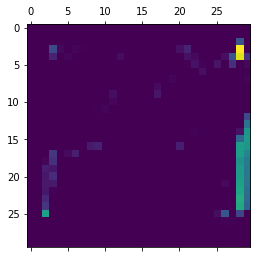

In [33]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

###### Superimposing the heatmap with the original picture

In [34]:
import cv2

img = cv2.imread(img_path)

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

heatmap = np.uint8(255 * heatmap)

heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = heatmap * 0.4 + img

cv2.imwrite('/Users/ellischang/ellis_venv/URE18/Image_Processing/00001220_000.jpg', superimposed_img)

True

In [35]:
print(img.shape)
print(heatmap.shape)

(1024, 1024, 3)
(1024, 1024, 3)


In [36]:
import cv2

for subdir, dirs, files in os.walk(TEST_DIR):
        for filename in tqdm(files):
            path = subdir + os.sep + filename
            img = cv2.imread(path)

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

heatmap = np.uint8(255 * heatmap)

heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

#superimposed_img = heatmap * 0.4 + img

#cv2.imwrite('/Users/ellischang/ellis_venv/URE18/Image_Processing/00001220_000.jpg', superimposed_img)

100%|██████████| 500/500 [00:08<00:00, 57.73it/s]


In [37]:
print(img.shape)
print(heatmap.shape)

(1024, 1024, 3)
(1024, 1024, 3)


In [38]:
superimposed_img = heatmap * 0.4 + img

cv2.imwrite('/Users/ellischang/ellis_venv/URE18/Image_Processing/Heatmap Images/test.jpg', superimposed_img)

True

-Code is not predicting the right labels for the corresponding images. 
-Code is not printing out the heatmap for all the images. It is only doing the last image in the test folder
-Code is having a "true divide" error for the visualizations of each layer.
-Model may not be predicting anything right.

In [39]:
preds = model.predict(test_img) 
#preds = np.round_(preds)
for i in preds:
    print(i)

[3.2075029e-08 6.2800717e-01 7.6220895e-17 1.0192437e-01 1.2543922e-02 1.1126678e-03 6.1241608e-02
 1.5737877e-08 4.9636263e-01 1.3970244e-05 6.9285244e-02 5.9089542e-04 6.7624683e-07 6.1769923e-11
 9.1663259e-18]
[1.0876232e-05 5.3573150e-02 2.4988262e-15 1.4229718e-04 2.8729991e-03 8.4171060e-04 4.0309229e-03
 1.7901257e-06 3.7665433e-01 2.9492873e-04 5.0133127e-01 9.4447043e-03 3.0743252e-04 8.8194474e-09
 6.7204334e-20]
[6.9284375e-05 2.5214434e-02 2.1850926e-15 7.0744270e-04 7.8424281e-03 4.4877481e-04 4.3460969e-03
 2.4712054e-07 1.5445088e-01 2.4757019e-04 2.4195144e-01 7.1486545e-04 4.6035528e-04 8.9692150e-11
 4.1425034e-20]
[3.5899451e-05 3.5252232e-02 4.2828676e-14 4.2995665e-04 3.6230925e-02 1.9615653e-03 6.1212378e-03
 6.9200964e-06 6.9366825e-01 1.9051867e-04 1.9179124e-01 1.2215477e-02 3.0702772e-04 1.9534021e-08
 3.6459854e-19]
[8.7097491e-05 8.8216114e-04 3.3632033e-16 1.6297668e-05 1.5873844e-02 3.8135934e-04 3.8992675e-04
 1.5321255e-06 1.0997362e-01 4.0327737e-04 6.

[2.2503387e-04 2.9345584e-01 3.4043870e-12 7.5247693e-03 1.9350091e-01 1.3278323e-02 2.1292487e-02
 3.5295274e-05 1.6779722e-01 1.3633736e-04 1.3370922e-01 7.7904011e-03 6.8525749e-04 1.3812313e-07
 2.3949128e-14]
[1.9478702e-03 9.8786637e-02 1.1480091e-11 7.8820955e-04 6.9912940e-02 1.3481119e-03 2.2036866e-03
 1.4022998e-04 1.6298307e-01 6.8646052e-04 4.1728243e-01 1.3999677e-01 1.2552264e-02 6.4357448e-07
 2.5360392e-14]
[6.5354578e-04 9.9298358e-02 1.1329644e-12 1.4121425e-03 4.5345622e-01 2.6259280e-03 4.3586708e-04
 5.5107573e-04 1.5431494e-01 1.3274934e-04 7.8744268e-01 6.5331444e-02 6.9835358e-03 1.1338491e-07
 5.6793183e-16]
[8.1972120e-04 1.9687431e-02 5.3950229e-14 1.3508135e-04 2.2928918e-02 5.7803525e-04 9.8359799e-03
 1.6964741e-06 1.2943697e-01 1.2085894e-03 4.8175439e-01 1.5984347e-02 1.8767107e-03 4.5746922e-09
 3.2020813e-19]
[1.5784596e-03 1.1813611e-01 5.6393074e-11 9.1932984e-03 7.3343828e-02 1.3689935e-02 2.2568181e-02
 1.3901116e-03 3.6538079e-01 1.0449139e-03 6.

In [46]:
cnt = 4
preds = np.round_(preds)

In [47]:
print(preds[cnt])
print(test_labels[cnt])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]


In [55]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [56]:
rounded_preds = model.predict_classes(test_img)
for i in rounded_preds:
    print(i)

1
10
10
8
10
10
8
10
10
10
10
10
8
10
10
10
10
10
10
10
8
3
8
10
10
8
8
8
8
8
8
8
8
8
10
8
8
10
8
8
10
10
8
8
10
10
10
10
10
8
4
10
8
8
1
10
10
10
10
8
8
10
10
8
10
10
10
8
10
10
8
4
8
10
10
10
10
8
10
8
10
8
10
10
10
10
1
8
10
8
4
5
8
8
10
10
8
10
10
10
8
8
10
10
8
10
10
10
8
10
10
10
10
4
8
8
4
8
4
8
8
8
5
10
10
8
8
8
8
8
8
8
4
8
8
4
8
4
1
8
8
4
8
10
8
8
10
8
8
4
8
8
4
4
10
4
8
8
8
8
10
10
8
8
8
10
8
8
8
10
8
10
8
10
10
1
8
8
10
8
8
3
8
10
8
10
4
8
4
8
4
8
10
8
1
8
8
8
10
1
11
10
3
1
8
8
3
8
10
1
10
10
10
10
8
10
10
8
10
10
10
10
10
8
8
8
8
8
8
8
10
8
10
10
8
8
8
8
8
10
10
10
8
10
10
10
8
8
4
8
8
4
10
8
4
8
8
10
4
12
4
8
8
8
10
8
8
8
8
10
4
1
10
10
10
8
8
8
10
10
10
8
10
3
10
10
10
8
10
10
8
8
8
8
8
8
10
10
10
1
8
10
8
11
10
3
8
4
8
10
8
10
8
8
10
4
8
8
8
10
10
10
8
8
10
10
8
10
8
10
10
10
10
10
8
10
8
10
10
8
1
8
4
8
8
8
8
8
8
8
8
8
8
8
8
4
8
8
8
1
8
8
8
8
8
8
8
8
10
4
8
8
1
10
8
8
1
8
10
8
8
8
8
8
10
10
10
10
8
1
8
8
8
10
8
8
10
8
10
8
10
10
10
10
8
8
8
8
8
8
8
10
8
1
10
10
10
10
8

In [73]:
cm = confusion_matrix(test_labels.argmax(axis=1), rounded_preds)

In [76]:
def plot_confusion_matrix(cm, classes,
                         normalize = False,
                         title = 'Confusion Matrix',
                         cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45) 
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print("Confusion Matrix without Normalization")
    
    print(cm)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment = 'center',
                color='black' if cm[i, j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')

Confusion Matrix without Normalization
[[  0   6   0   0   2   1   0   0  20   0  13   0   0   0   0]
 [  0   0   0   0   2   0   0   0   4   0   2   0   0   0   0]
 [  0   1   0   1   3   0   0   0  14   0   9   0   0   0   0]
 [  0   0   0   0   3   0   0   0  13   0   2   0   0   0   0]
 [  0   1   0   0   1   0   0   0  19   0   7   0   0   0   0]
 [  0   0   0   0   4   0   0   0   7   0   4   0   0   0   0]
 [  0   1   0   0   0   0   0   0   5   0   5   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   1   0   0   0   0]
 [  0   6   0   1   6   0   0   0  29   0  20   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   2   0   0   0   0]
 [  0   4   0   4  10   1   0   0 116   0 127   1   1   0   0]
 [  0   0   0   0   1   0   0   0   6   0   1   1   0   0   0]
 [  0   0   0   0   1   0   0   0   3   0   4   0   0   0   0]
 [  0   0   0   0   0   0   0   0   2   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   1   0   1   0   0   0   0]]


<Figure size 432x288 with 0 Axes>

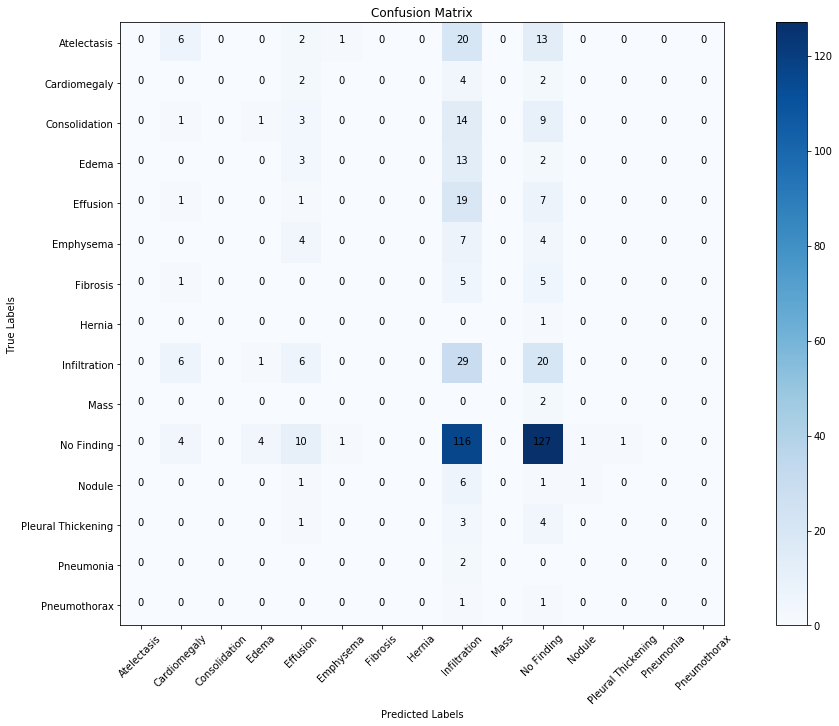

In [80]:
cm_plot_labels = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 
                  'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural Thickening', 'Pneumonia',
                   'Pneumothorax']
plt.clf()
plt.figure(figsize = (15, 10))
plot_confusion_matrix(cm, cm_plot_labels, title = 'Confusion Matrix', normalize=False)

Normalized Confusion Matrix
[[0.         0.14285714 0.         0.         0.04761905 0.02380952 0.         0.
  0.47619048 0.         0.30952381 0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.25       0.         0.         0.
  0.5        0.         0.25       0.         0.         0.         0.        ]
 [0.         0.03571429 0.         0.03571429 0.10714286 0.         0.         0.
  0.5        0.         0.32142857 0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.16666667 0.         0.         0.
  0.72222222 0.         0.11111111 0.         0.         0.         0.        ]
 [0.         0.03571429 0.         0.         0.03571429 0.         0.         0.
  0.67857143 0.         0.25       0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.26666667 0.         0.         0.
  0.46666667 0.         0.26666667 0.         0.         0.         0.        ]


<Figure size 432x288 with 0 Axes>

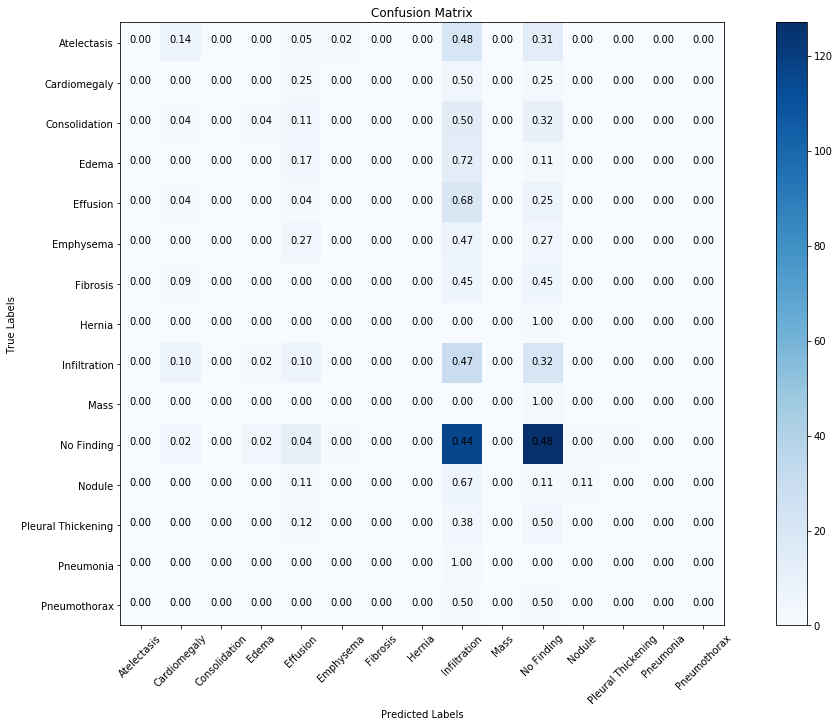

In [84]:
plt.clf()
plt.figure(figsize = (15, 10))
plot_confusion_matrix(cm, cm_plot_labels, title = 'Confusion Matrix', normalize=True)

In [103]:
preds[0:10]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [91]:
print(rounded_preds)

[ 1 10 10  8 10 10  8 10 10 10 10 10  8 10 10 10 10 10 10 10  8  3  8 10 10  8  8  8  8  8  8  8  8
  8 10  8  8 10  8  8 10 10  8  8 10 10 10 10 10  8  4 10  8  8  1 10 10 10 10  8  8 10 10  8 10 10
 10  8 10 10  8  4  8 10 10 10 10  8 10  8 10  8 10 10 10 10  1  8 10  8  4  5  8  8 10 10  8 10 10
 10  8  8 10 10  8 10 10 10  8 10 10 10 10  4  8  8  4  8  4  8  8  8  5 10 10  8  8  8  8  8  8  8
  4  8  8  4  8  4  1  8  8  4  8 10  8  8 10  8  8  4  8  8  4  4 10  4  8  8  8  8 10 10  8  8  8
 10  8  8  8 10  8 10  8 10 10  1  8  8 10  8  8  3  8 10  8 10  4  8  4  8  4  8 10  8  1  8  8  8
 10  1 11 10  3  1  8  8  3  8 10  1 10 10 10 10  8 10 10  8 10 10 10 10 10  8  8  8  8  8  8  8 10
  8 10 10  8  8  8  8  8 10 10 10  8 10 10 10  8  8  4  8  8  4 10  8  4  8  8 10  4 12  4  8  8  8
 10  8  8  8  8 10  4  1 10 10 10  8  8  8 10 10 10  8 10  3 10 10 10  8 10 10  8  8  8  8  8  8 10
 10 10  1  8 10  8 11 10  3  8  4  8 10  8 10  8  8 10  4  8  8  8 10 10 10  8  8 10 10  8 10  8 10


In [104]:
test_labels[0:10]

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])

In [98]:
(preds==test_labels).all()

False

In [102]:
np.where(preds==test_labels)

(array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   2,   2,   2,   2,   2,   2,   2,   2,
          2,   2,   2,   2,   2,   2,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
          3,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   5,   5,
          5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   6,   6,   6,   6,   6,   6,
          6,   6,   6,   6,   6,   6,   6,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,
          9,   9,   9,   9,   9,   9,   9,   9,   9,   9,   9,   9,   9,   9,  10,  10,  10,  10,
         10,  10,  10,  10,  10,  10,  10,  10,  10,  10,  11,  11,  11,  11,  11,  11,  11,  11,
         11,  11,  11,  11,  11,  11,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,
         12,  12,  1